In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits
import astropy.wcs as wcs

from reproject import reproject_interp

import sys
import time

# CAN ALSO WORK WITH PYPATH
sys.path.insert(0,'libraries/')
from colDens_phdu import ColDens_PrimaryHDU
from regression_on_intensities import Regressor
from molecule_hdulist import Molecule_HDUList
import plotting_functions as plfunc

In [2]:
#### USER INPUT ####

## for the fits files to open
file_name_1 = 'Ipeak_4sigmaMusca_C18O21_TP_kelvin_Smto10'
path_1 = '../data/ALMA/fitting_results/'
label_1 = 'C$^{18}$O(2-1)'
cal_unc_1 = 0.1 ## 10%

file_name_2 = 'Ipeak_4sigmaMusca_C18O10_TP_kelvin'
path_2 = '../data/ALMA/fitting_results/'
label_2 = 'C$^{18}$O(1-0)'
cal_unc_2 = 0.1 ## 10%

file_name_cont = 'musca_coldens_high250_clean_2d'
path_cont = '../data/Herschel/'
label_cont = 'N$_{H_{2}}$ (cm$^{-2}$)'

## contour information
levs_cont = [2.0e21 + i*1.0e21 for i in range(0,6)]
wids_cont = [0.7 for lev in levs_cont]

## information to map density with constraints from Herschel
file_name_colDens = 'musca_coldens_high250_clean_2d'
path_colDens = '../data/Herschel/'
label_colDens = 'N$_{H_{2}}$ (cm$^{-2}$)'

file_name_Tdust = 'musca_temp_r500_clean_2d'
path_Tdust = '../data/Herschel/'
label_Tdust = 'T$_{dust}$ (K)'

## plotting information
label_map = 'T$_{C^{18}O(2-1)}$/T$_{C^{18}O(1-0)}$'
x1_pl = 60.
x2_pl = 300.
y1_pl = 25.
y2_pl = 345.

background_colDens = 1.0e21 ## the overall background of the region (Cox+2016; Bonne+2020b)
max_colDens = 5.5e21 - background_colDens
crest_colDens = 3.0e21 - background_colDens

pc_in_cm = 3.09e18

## information for the density calculation (fixed mol. col. density, linewidth and kinetic temperature)
mol = 'c18o'
line_1 = '2-1'
line_2 = '1-0'
fwhm = '0p25'
fit_order = 4 ## order of the polynomial that will be fitted
min_dens = 1e3
max_dens = 1e4
label_density = "n$_{H_{2}}$ (cm$^{-3}$)"
standard_c18o_abundance = 1./(7.3*60*1e4)
grid_path = '../Radex/bin/results/smallGrid-FWHM=0p25/'


#### END OF THE USER INPUT

In [3]:
## open the fits files
hdu_1 = pyfits.open(path_1 + file_name_1 + '.fits')
hdu_1.info()
data_1 = hdu_1[0].data
header_1 = hdu_1[0].header
w_1 = wcs.WCS(header_1)

hdu_2 = pyfits.open(path_2 + file_name_2 + '.fits')
hdu_2.info()
data_2 = hdu_2[0].data
header_2 = hdu_2[0].header
w_2 = wcs.WCS(header_2)

hdu_3 = pyfits.open(path_cont + file_name_cont + '.fits')
hdu_3.info()

hdu_N = pyfits.open(path_colDens + file_name_colDens + '.fits')
hdu_N.info()
data_N = hdu_N[0].data
header_N = hdu_N[0].header
w_N = wcs.WCS(header_N)

hdu_T = pyfits.open(path_Tdust + file_name_Tdust + '.fits')
hdu_T.info()
data_T = hdu_T[0].data
header_T = hdu_T[0].header

Filename: ../data/ALMA/fitting_results/Ipeak_4sigmaMusca_C18O21_TP_kelvin_Smto10.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     101   (360, 385)   float64   
Filename: ../data/ALMA/fitting_results/Ipeak_4sigmaMusca_C18O10_TP_kelvin.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      79   (360, 385)   float64   
Filename: ../data/Herschel/musca_coldens_high250_clean_2d.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      23   (2800, 3800)   float32   
Filename: ../data/Herschel/musca_coldens_high250_clean_2d.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      23   (2800, 3800)   float32   
Filename: ../data/Herschel/musca_temp_r500_clean_2d.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      24   (2800, 3800)   float32   


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [4]:
## reproject Herschel maps to the grid of the spectral line data
arr_colDens, footprint_colDens = reproject_interp(hdu_N, header_1)
arr_Tdust, footprint_Tdust = reproject_interp(hdu_T, header_1)

In [5]:
## remove the background column density
arr_colDens = arr_colDens - background_colDens
data_N = data_N - background_colDens

In [6]:
## store the reprojected column density files in HDU format
header_c = header_1.copy()
header_c['BUNIT'] = header_N['BUNIT']
colDens_hdu_rep = pyfits.HDUList(ColDens_PrimaryHDU(arr_colDens, header_c)) ## creates a HDU List specifically with the Column density extension

header_c['BUNIT'] = header_T['BUNIT']
Tdust_hdu_rep = pyfits.HDUList(pyfits.PrimaryHDU(arr_Tdust, header_c))

hdu_N = pyfits.HDUList(pyfits.PrimaryHDU(data_N, header_N))

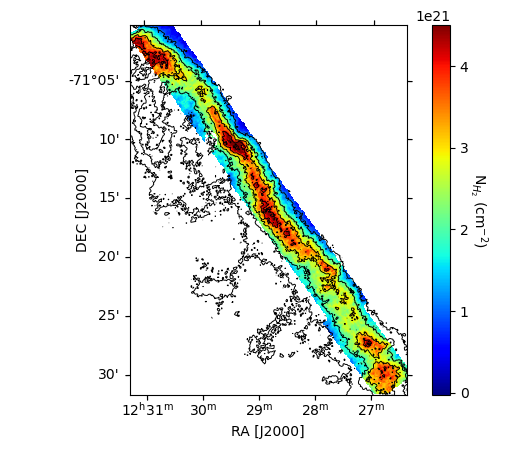

In [7]:
## filter the Herschel images based on the ALMA images mask
mask = np.zeros((len(data_1),len(data_1[0])), dtype=int)
mask[np.isnan(data_1)] = 1
colDens_hdu_rep[0].data[mask==1] = np.nan
Tdust_hdu_rep[0].data[mask==1] = np.nan

## verify
plfunc.plot_hdu(colDens_hdu_rep, label_colDens, max_val = max_colDens, contour_hdu = hdu_3, plot_lims = [x1_pl,x2_pl,y1_pl,y2_pl], levs_cont = levs_cont, wids_cont = wids_cont)

In [8]:
## store the molecular line data in a dedicated HDUList
im_list = [hdu_1[0], hdu_2[0]]
im_list_mol = Molecule_HDUList(im_list, mol, [line_1, line_2])
print(im_list_mol.transitions)

['2-1', '1-0']


Reading data input
----> Done


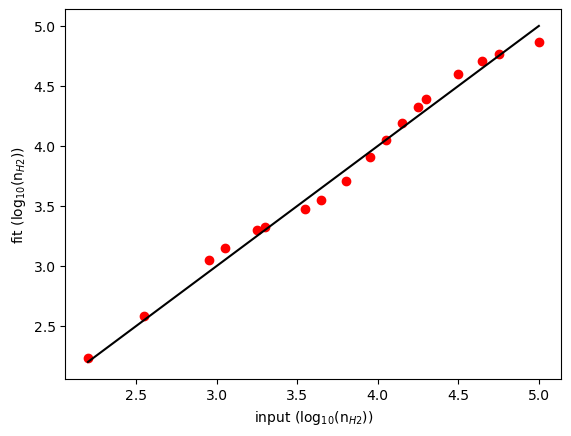

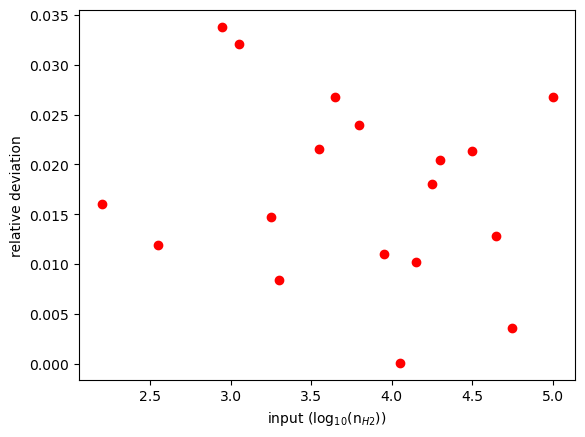

In [9]:
## create the Regressor
regressor = Regressor()

## create a model for the regressor based on the grid in the grid_path
regressor.create_dens_SVRregression_model_for_molecule(grid_path, im_list_mol, Tkin = 10.31, Nmol = 7.1e14)
#regressor.create_dens_SVRregression_model_for_molecule(grid_path, im_list_mol, Tkin = [10.31], Nmol = [7.1e14])


# create_dens_SVRregression_model_for_molecule
outputs = regressor.predict_map(im_list_mol)

## perform the above in a single step
#outputs = regressor.map_from_dens_SVRregression(grid_path, im_list_mol, Tkin = 10.31, Nmol = 7.1e14)

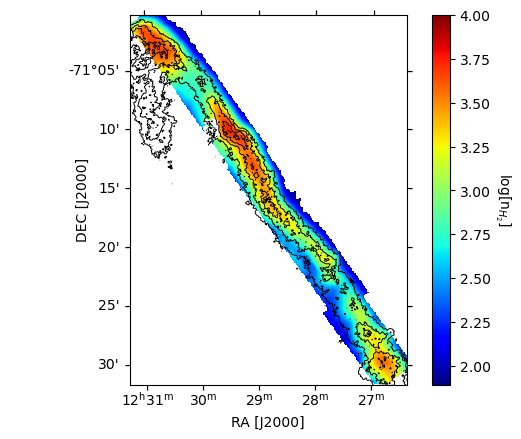

In [10]:
## plot the result
fig, ax = plt.subplots()
ax1 = fig.add_subplot(111, projection = w_1)
im = ax1.imshow(outputs[0].data, origin='lower', cmap='jet', vmax = 4)
    
ax1.contour(data_N, colors = 'k', levels=levs_cont,linewidths=wids_cont, transform=ax1.get_transform(w_N))
            
plt.xlim([x1_pl, x2_pl])
plt.ylim([y1_pl, y2_pl])

plt.xlabel('RA [J2000]')
plt.ylabel('DEC [J2000]',labelpad=-1.)

cbar = fig.colorbar(im)
cbar.set_label('log[n$_{H_{2}}$]', labelpad=15.,rotation=270)

ax.axis('off')

#plt.savefig("../plots/ALMA_regression/density_T=10p3_N=7p1e14.pdf")
plt.show()

In [11]:
## depth in the line-of-sight (LOS)
## Assuming cylinder is well resolved, so can do N/n
los_map = arr_colDens/(10.**outputs[0].data)/pc_in_cm

## store in hdu
header_c['BUNIT'] = 'log10[LOS (pc)]'
los_log_hdu = pyfits.HDUList(ColDens_PrimaryHDU(np.log10(los_map), header_c))

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


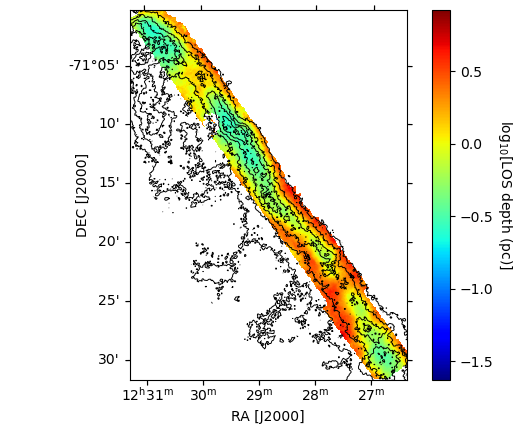

In [12]:
## plot the LOS depth map on a logscale
plfunc.plot_hdu(los_log_hdu, 'log$_{10}$[LOS depth (pc)]', contour_hdu = hdu_3, 
                plot_lims = [x1_pl,x2_pl,y1_pl,y2_pl], levs_cont = levs_cont, wids_cont = wids_cont)

1.0759802898988116
1.3455584449634188


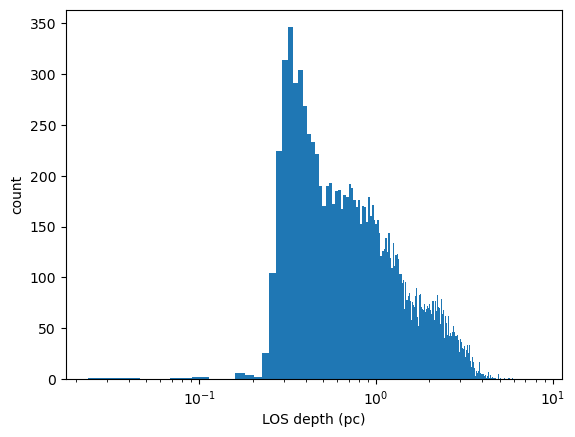

In [13]:
## Overview of the depth in the map
## to 1D
los_arr = los_map.ravel()

## plot mean median
print(np.nanmedian(los_arr))
print(np.nanmean(los_arr))

## histogram of LOS depths
plt.hist(los_arr, bins = int( np.sqrt(len(los_arr)) + 0.5))

plt.xscale('log')
plt.xlabel('LOS depth (pc)')
plt.ylabel('count')
plt.show()

In [14]:
## create a map with data from the crest and the ambient gas and store in a HDU
crest_los_map = los_map.copy()  ## filament crest
crest_los_map[arr_colDens < crest_colDens] = np.nan
header_c['BUNIT'] = 'LOS (pc)'
crest_los_hdu = pyfits.HDUList(ColDens_PrimaryHDU(crest_los_map, header_c))

ambient_los_map = los_map.copy() ## ambient gas
ambient_los_map[arr_colDens > crest_colDens] = np.nan
header_c['BUNIT'] = 'LOS (pc)'
ambient_los_hdu = pyfits.HDUList(ColDens_PrimaryHDU(ambient_los_map, header_c))

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


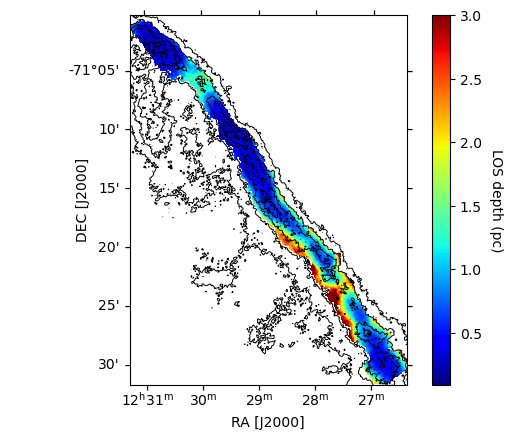

In [15]:
## plot the LOS depth map of the crest
plfunc.plot_hdu(crest_los_hdu, 'LOS depth (pc)', contour_hdu = hdu_3, max_val = 3., 
                plot_lims = [x1_pl,x2_pl,y1_pl,y2_pl], levs_cont = levs_cont, wids_cont = wids_cont)

0.7905931794044349
1.030657602196179


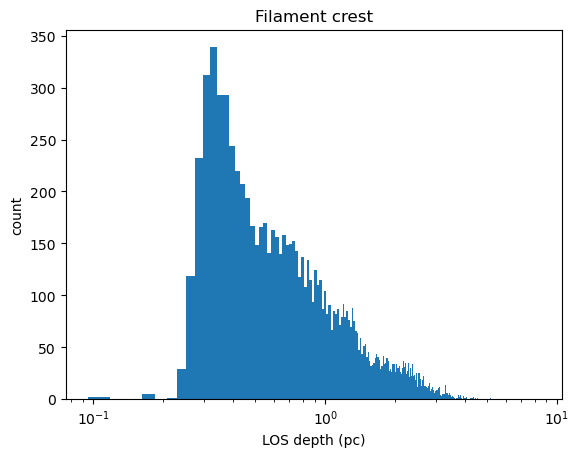

In [16]:
## to 1D
crest_los_arr = crest_los_map.ravel()

## plot mean median
print(np.nanmedian(crest_los_arr))
print(np.nanmean(crest_los_arr))

## histogram of LOS depths
plt.hist(crest_los_arr, bins = int(np.sqrt(len(crest_los_arr)) + 0.5))

plt.title('Filament crest')
plt.xscale('log')
plt.xlabel('LOS depth (pc)')
plt.ylabel('count')
plt.show()

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


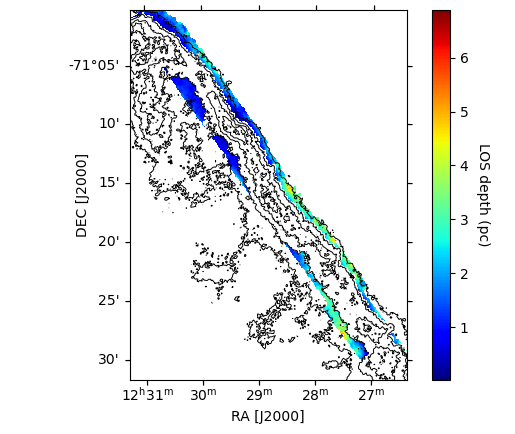

In [17]:
## plot the LOS depth map of the ambient gas
plfunc.plot_hdu(ambient_los_hdu, 'LOS depth (pc)', contour_hdu = hdu_3, 
                plot_lims = [x1_pl,x2_pl,y1_pl,y2_pl], levs_cont = levs_cont, wids_cont = wids_cont)

1.8336172962767612
1.9256290677247647


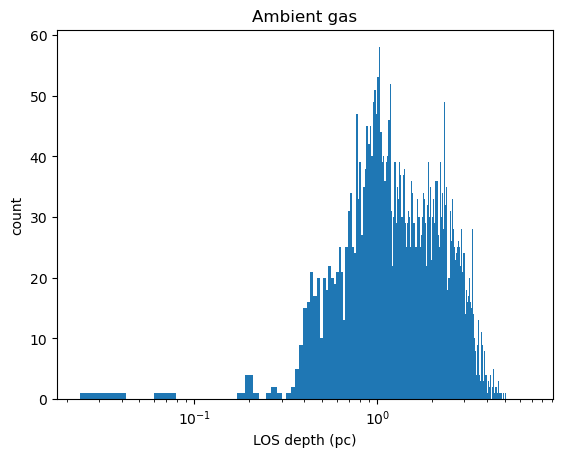

In [18]:
## to 1D
ambient_los_arr = ambient_los_map.ravel()

## plot mean median
print(np.nanmedian(ambient_los_arr))
print(np.nanmean(ambient_los_arr))

## histogram of LOS depths
plt.hist(ambient_los_arr, bins = int(np.sqrt(len(ambient_los_arr)) + 0.5))

plt.title('Ambient gas')
plt.xscale('log')
plt.xlabel('LOS depth (pc)')
plt.ylabel('count')
plt.show()

In [19]:
## TO DO: Also plot the densities for the crest and ambient gas

In [20]:
#### test exceptions ####

## Test Nmol verification
#regressor.create_dens_SVRregression_model_for_molecule(grid_path, im_list_mol, Tkin = 10.31, Nmol = 12.3e19)

## Test Tkin verification
#regressor.create_dens_SVRregression_model_for_molecule(grid_path, im_list_mol, Tkin = 55., Nmol = 7.1e14)